# Working with CGX data using MNE
The goal of this notebook is to import data saved using the [CGX data collection software](http://cognionics.com/wiki/pmwiki.php/Main/DataAcquisitionSoftware), and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib.pyplot as plt

## Local Drive Folder (optional)
Since experimental data is uploaded to the workshop's shared drive, it might be easier to sync the drive folder to your local machine using [Google Drive for desktop](https://www.google.com/drive/download/).

There is a streaming option so the files remain in the cloud unless you want them available offline. 

Then you could add the shared AC23 folder as a shortcut on your My Drive, so the files will be viewable from your locally sync'd drive folder:

<div>
<img src="ac23_shortcut.png" width="500"/>
</div>

## Path to dataset

This example's dataset was saved using BrainVision's .eeg format. 

We could also use CGX's .txt output, or some of the other formats supported by the CGX's data acquisition software.

In [2]:
DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/mountain_biking/mb_test_Karan.bdf'

We can import this dataset following the instructions here:
https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html

Format | Function
:-- | :--
.eeg, .vhdr, .vhdk | [mne.io.read_raw_brainvision](https://mne.tools/stable/generated/mne.io.read_raw_brainvision.html#mne.io.read_raw_brainvision)
.bdf | [mne.io.read_raw_bdf](https://mne.tools/stable/generated/mne.io.read_raw_bdf.html)

In [3]:
raw = mne.io.read_raw_bdf(
    DATA_PATH,
    eog = ['ExG 1', 'ExG 2'], # in case these were used as EMG channels, just to separate from EEG channels
    misc = ['ACC32', 'ACC33', 'ACC34', 'Packet Counter'], # keeping aside these as units would be different
    stim_channel = ['TRIGGER'], # should get the triggers streamed from the trigger box (if used), not LSL
    exclude = ['A2'], # assuming only one ground reference was used
    preload = True, # load data to memory
)

'''
mne.io.read_raw_brainvision(
    vhdr_fname=DATA_PATH,
    # can provide more input args here
)
'''

raw.info

Extracting EDF parameters from /Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/mountain_biking/mb_test_Karan.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57999  =      0.000 ...   115.998 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: AF7, Fpz, F7, Fz, T7, FC6, Fp1, F4, C4, Oz, CP6, Cz, PO8, CP5, ...
 chs: 29 EEG, 2 EOG, 4 misc, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-07-01 22:33:15 UTC
 nchan: 36
 projs: []
 sfreq: 500.0 Hz
>

In [4]:
raw[0] # the 0th channels raw data and corresponding time arrayy, could be useful to figure out units

(array([[-0.00475491, -0.00471875, -0.00465795, ..., -0.00700449,
         -0.00702823, -0.00705942]]),
 array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 1.15994e+02,
        1.15996e+02, 1.15998e+02]))

In [5]:
# Printing all channel names for reference
for ch in raw.info.ch_names:
    print(ch)

AF7
Fpz
F7
Fz
T7
FC6
Fp1
F4
C4
Oz
CP6
Cz
PO8
CP5
O2
O1
P3
P4
P7
P8
Pz
PO7
T8
C3
Fp2
F3
F8
FC5
AF8
ExG 1
ExG 2
ACC32
ACC33
ACC34
Packet Counter
TRIGGER


## Apply the 10-20 channel montage

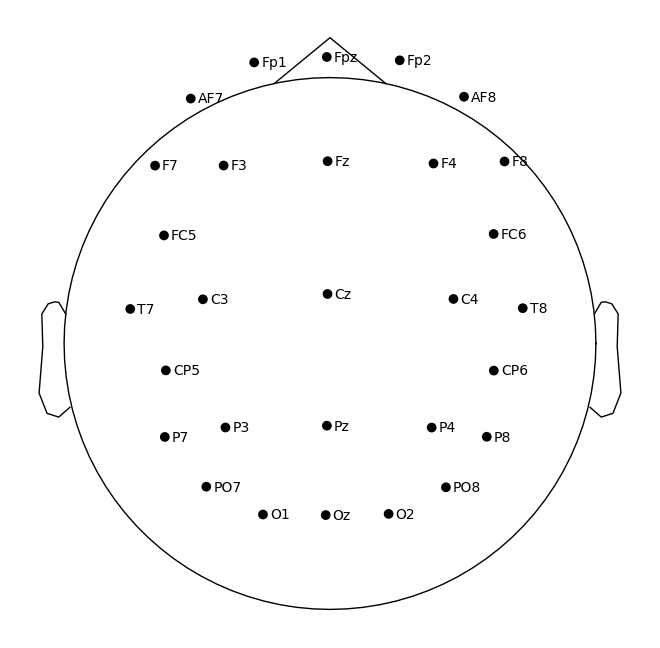

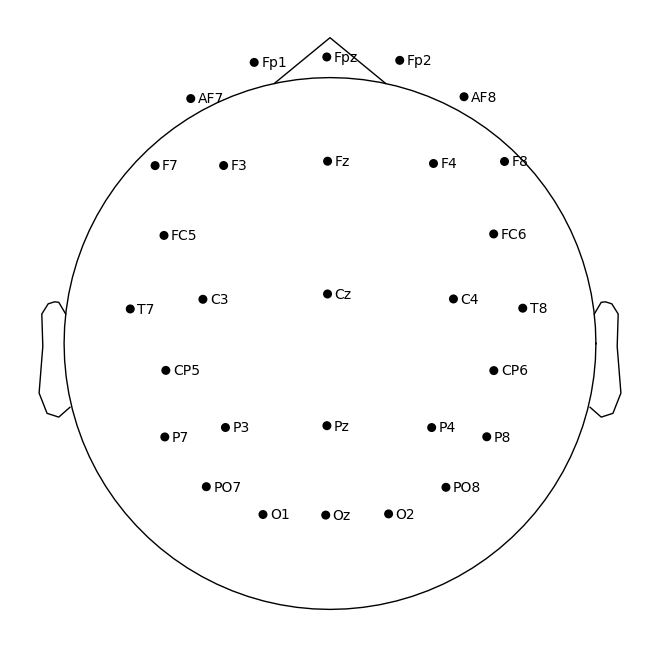

In [6]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

Using matplotlib as 2D backend.


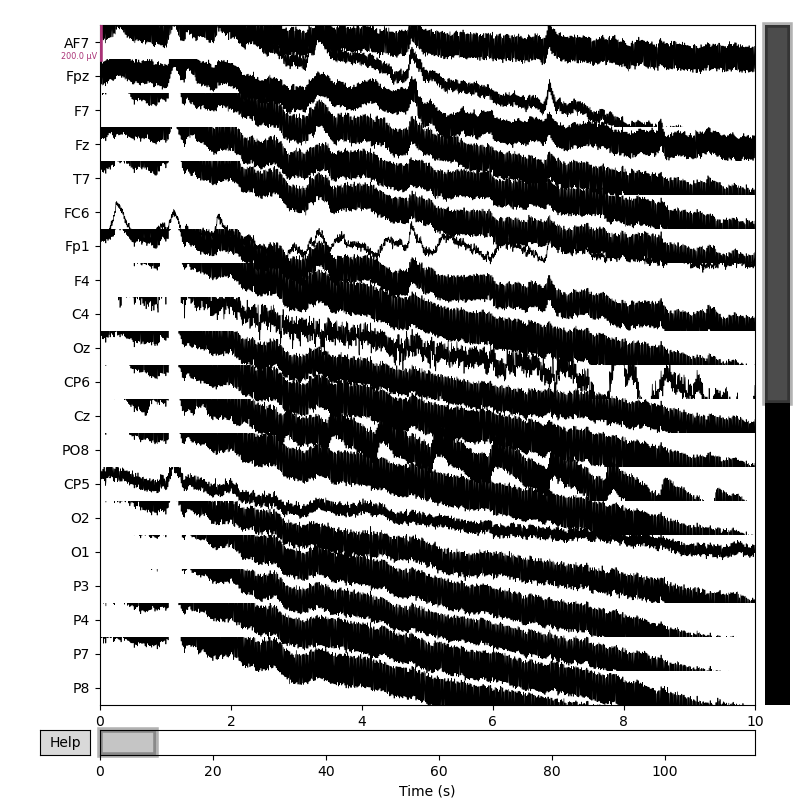

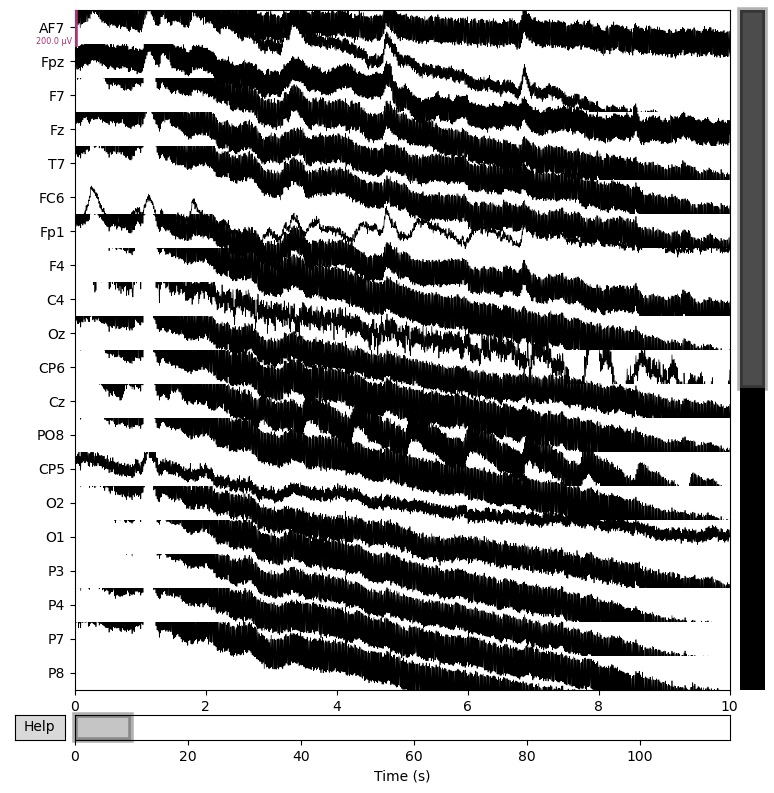

In [7]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {'eeg': 100e-6, 'misc': 1e2} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

raw.plot(scalings=scalings)

Let's look at a power spectrum (before we do any filtering):

Effective window size : 2.048 (s)


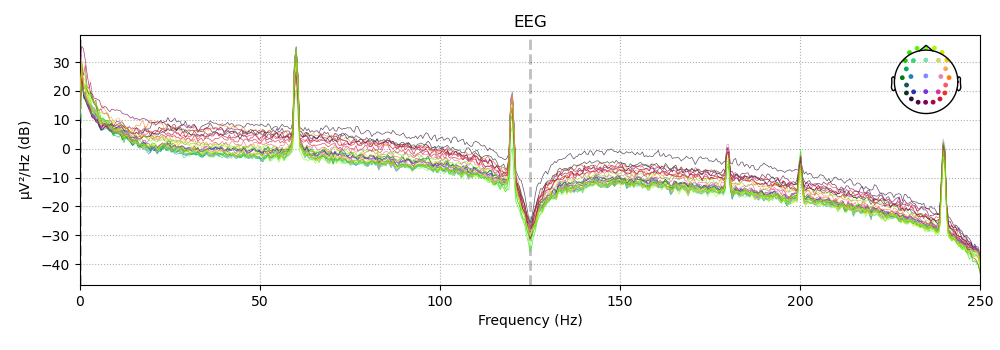

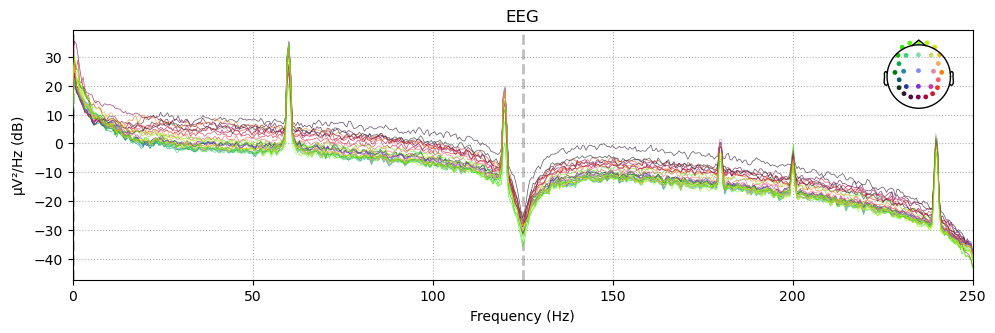

In [8]:
raw.compute_psd(n_fft = 1024).plot(average = False)

Let's bandpass filter the data:

In [9]:
raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
    l_freq = 0.1, # lower cut-off, in Hz
    h_freq = 50, # upper cut-off, in Hz
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.1s finished


Effective window size : 2.048 (s)


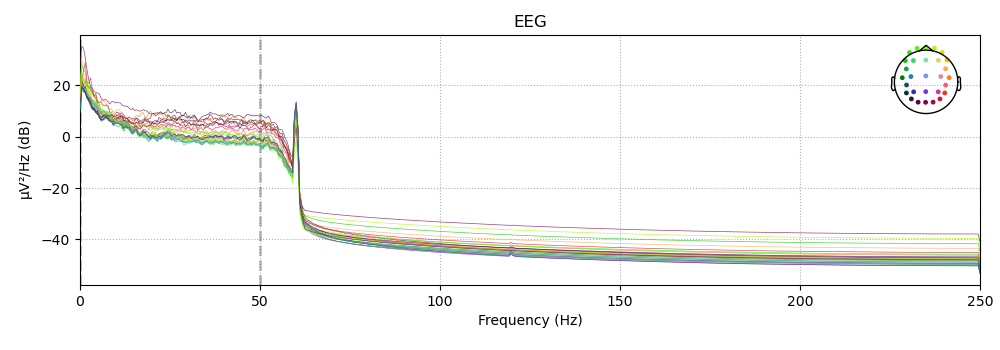

Effective window size : 2.048 (s)


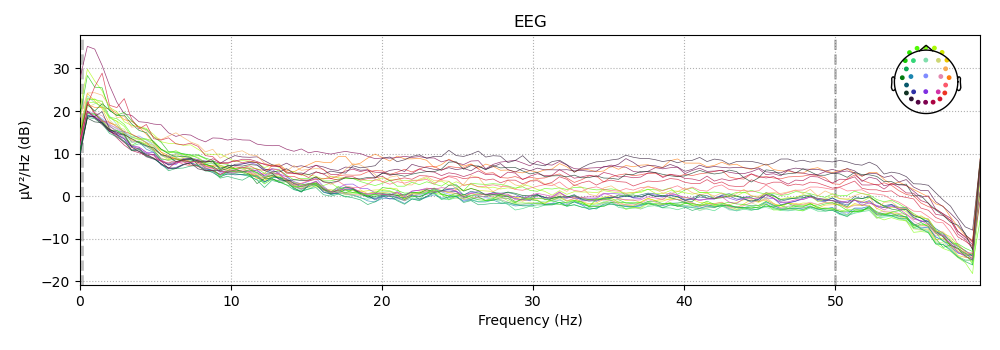

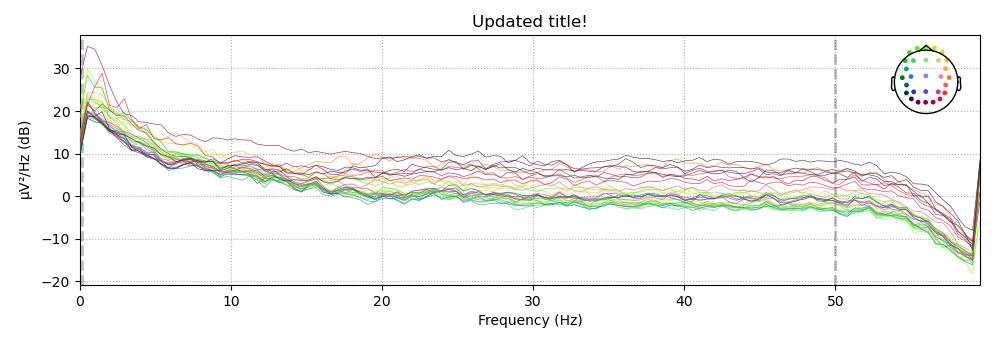

In [10]:
# And look at the PSD again
raw_filt.compute_psd(n_fft = 1024).plot(average = False)

n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
fig = raw_filt.compute_psd(
    # picks= picks,
    fmin = 0, # lower limit to plot
    fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Some reformatting if needed
# fig.get_axes()[0].set_ylim(YLIM_MIN, YLIM_MAX)
fig.get_axes()[0].set_title('Updated title!')
plt.show()

# Lets find events from the trigger channel

In [11]:
ev = mne.find_events(raw_filt)

22 events found
Event IDs: [32768]


In [12]:
ev

array([[ 4576,     0, 32768],
       [ 8166,     0, 32768],
       [ 8210,     0, 32768],
       [12146,     0, 32768],
       [12200,     0, 32768],
       [14179,     0, 32768],
       [20096,     0, 32768],
       [20137,     0, 32768],
       [24040,     0, 32768],
       [24091,     0, 32768],
       [26057,     0, 32768],
       [31972,     0, 32768],
       [32016,     0, 32768],
       [35934,     0, 32768],
       [35988,     0, 32768],
       [37943,     0, 32768],
       [43829,     0, 32768],
       [43873,     0, 32768],
       [47815,     0, 32768],
       [47869,     0, 32768],
       [49836,     0, 32768],
       [51633,     0, 32768]])

Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 651 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


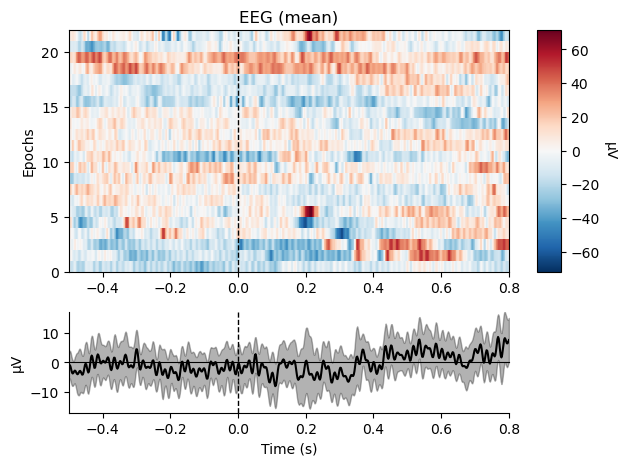

[<Figure size 640x480 with 3 Axes>]

In [17]:
eps = mne.Epochs(
    #raw_filt,
    raw_filt,
    events=ev, 
    event_id = {'bad contact': 32768}, 
    tmin=-0.5,
    tmax=0.8,
    baseline=None,
)

%matplotlib inline
eps['bad contact'].plot_image(
    #picks = [],
    combine='mean'
)

No projector specified for this dataset. Please consider the method self.add_proj.


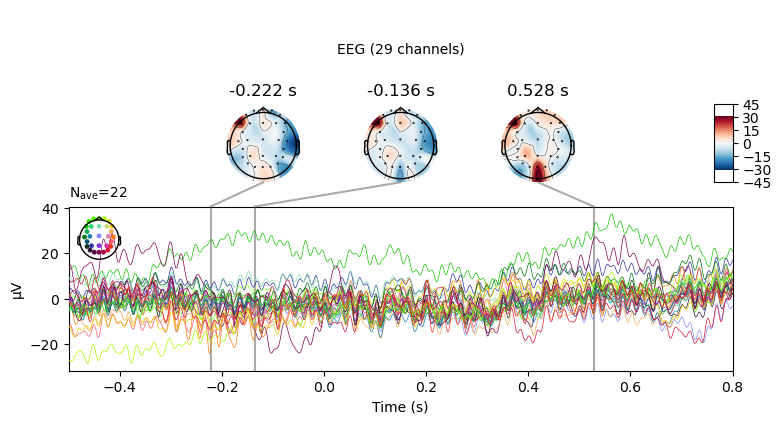

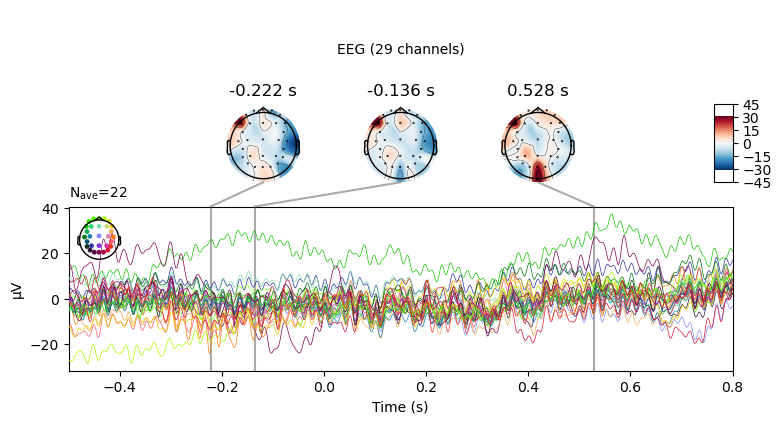

In [18]:
eps['bad contact'].average(
    # picks = []
).plot_joint()